In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms.functional as F

from score_models.models.unet import UNet
from score_models.sampling import annealed_langevin_dynamics
from score_models.utils.noise import get_sigmas

%load_ext autoreload
%autoreload 2

In [2]:
L=10
in_ch = 3
ch = 128
ch_mult = [1, 2, 3, 4]
attn = [2]
num_res_blocks = 2
dropout = 0.15

lr = 1e-4
sigma_min = 0.01
sigma_max = 1.0
device = "cuda"

# define score model
score_model = UNet(
    in_ch=in_ch, ch=ch, ch_mult=ch_mult, 
    T=L, attn=attn, num_res_blocks=num_res_blocks, dropout=dropout,
).to(device)

path = "../scripts/checkpoints/cifar10_1e-4/140000.pt"
score_model.load_state_dict(
    torch.load(path)["model_state_dict"]
)

# define train step (i.e., criterion)
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)

In [3]:
samples = annealed_langevin_dynamics(
    score_model=score_model, 
    input_size=(16, 3, 32, 32), 
    sigmas=sigmas,
    T=100,
    eps=2e-5,
    r=[0, 1]
).cpu()

samples = torch.clamp(samples, 0, 1)

In [4]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


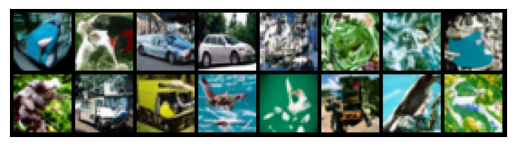

In [5]:
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=True, value_range=(0, 1))
show(grid)